# Ringdown fit from IMR results

We will show how to initialize a ringdown fit starting from a reference set of inspiral-merger-ringdown (IMR) parameter estimation (PE) samples, as would be produced in a regular GW analysis. This can be useful when launching a first exploratory fit for an event for which we have IMR results for some reference waveform.

<div class="alert alert-info">

Note

The [GWpy package](http://gwpy.github.io/) is only an _optional_ dependence for `ringdown`: you should install it before running this notebook (e.g., `pip install gwpy`); alternatively, you can download the data separately and load it directly from disk as in the GW150914 example.

</div>

In [1]:
%pip install gwpy

## Preliminaries

We begin with some standard imports and global settings.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

We will make use of a number of external data products in this example.

In [3]:
!wget -nc https://zenodo.org/records/8115310/files/GW150914_095045_NRSur7dq4.h5
!wget -nc https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW150914_PSDs.dat
!wget -nc https://zenodo.org/records/13376190/files/NRSur7dq4.h5
!wget -nc https://dcc-llo.ligo.org/public/0161/T1900393/003/NRSur7dq4Remnant.h5

/Users/maxisi/opt/miniconda3/envs/ringdown-jax/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


File ‘GW150914_095045_NRSur7dq4.h5’ already there; not retrieving.

File ‘GWTC1_GW150914_PSDs.dat’ already there; not retrieving.

File ‘NRSur7dq4.h5’ already there; not retrieving.

File ‘NRSur7dq4Remnant.h5’ already there; not retrieving.



We will turn on logging to see details:

In [4]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [5]:
psds_o1 = np.loadtxt('GWTC1_GW150914_PSDs.dat')

psds_o1 ={
    'H1': rd.PowerSpectrum(psds_o1[:,1], index=psds_o1[:,0], ifo='H1'),
    'L1': rd.PowerSpectrum(psds_o1[:,2], index=psds_o1[:,0], ifo='L1')
}

INFO:root:completing power spectrum to next power of two
INFO:root:completing power spectrum to next power of two


In [6]:
fit = rd.fit.Fit.from_imr_result('GW150914_095045_NRSur7dq4.h5', psds=psds_o1, modes=[(1,-2,2,2,0), (1, -2,2,2,1)])

INFO:root:completing low frequencies with 10x max PSD
INFO:root:completing low frequencies with 10x max PSD
INFO:root:loading data based on IMR result
INFO:root:missing local data for H1: /anvil/projects/x-phy990007n/vvarma/Work/Projects/Current/NRSurCatalog/runs/GWTC/Data/GW150914_095045/H1_data.gwf
INFO:root:fetching 4.0 s long segment centered on 1126259462.391 [1126259460.391, 1126259464.391]
INFO:root:fetching open data from GWOSC
INFO:root:fetching 4.0 s long segment centered on 1126259462.391 [1126259460.391, 1126259464.391]
INFO:root:fetching open data from GWOSC
INFO:root:completing power spectrum to next power of two
INFO:root:completing power spectrum to next power of two


waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:caching waveforms
INFO:root:estimated duration automatically: 0.2578125
INFO:root:setting target: SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 416838169), ra=0.9926919577221156, dec=-1.0174041542286454, psi=1.502597197526817, duration=0.2578125)
INFO:root:conditioning data based on IMR result
INFO:root:loading ACFs based on IMR result
INFO:root:completing power spectrum to next power of two
INFO:root:completing power spectrum to next power of two
INFO:root:using cached waveforms
INFO:root:estimating mass prior
INFO:root:quantiles [0.0050000000000000044, 0.5, 0.995]: 63.16077316601783, 67.22847210028883, 72.11265355541224
INFO:root:updated model: {'a_scale_max': 6.033146630698385e-20, 'm_max': 117.0, 'm_min': 33.0}


In [21]:
fit.target

SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 416838169), ra=0.9926919577221156, dec=-1.0174041542286454, psi=1.502597197526817, duration=0.2578125)

In [22]:
snrs = fit.compute_imr_snr(cumulative=True, nsamp=100)

waveforms:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:wiping waveform cache


In [23]:
# fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=0.2)

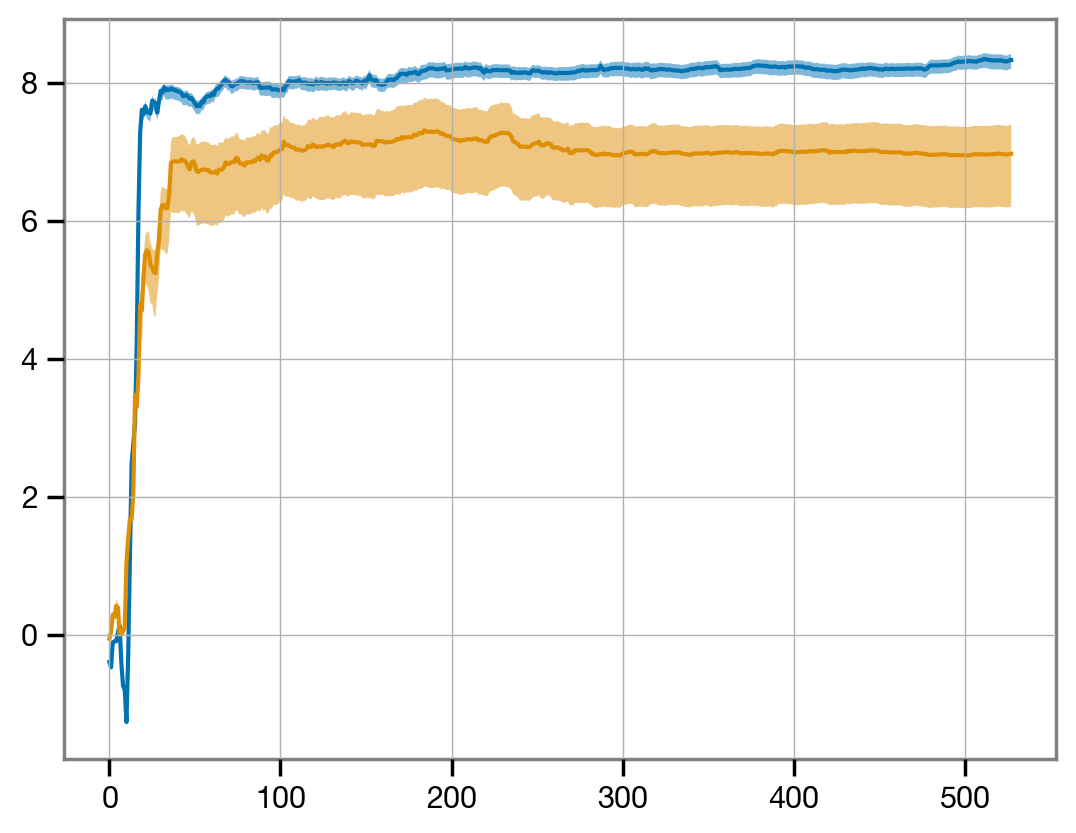

In [24]:
for s in snrs:
    l, m, h = np.quantile(s, [0.05, 0.5, 0.95], axis=1)
    plt.plot(m)
    plt.fill_between(np.arange(len(m)), l, h, alpha=0.5)

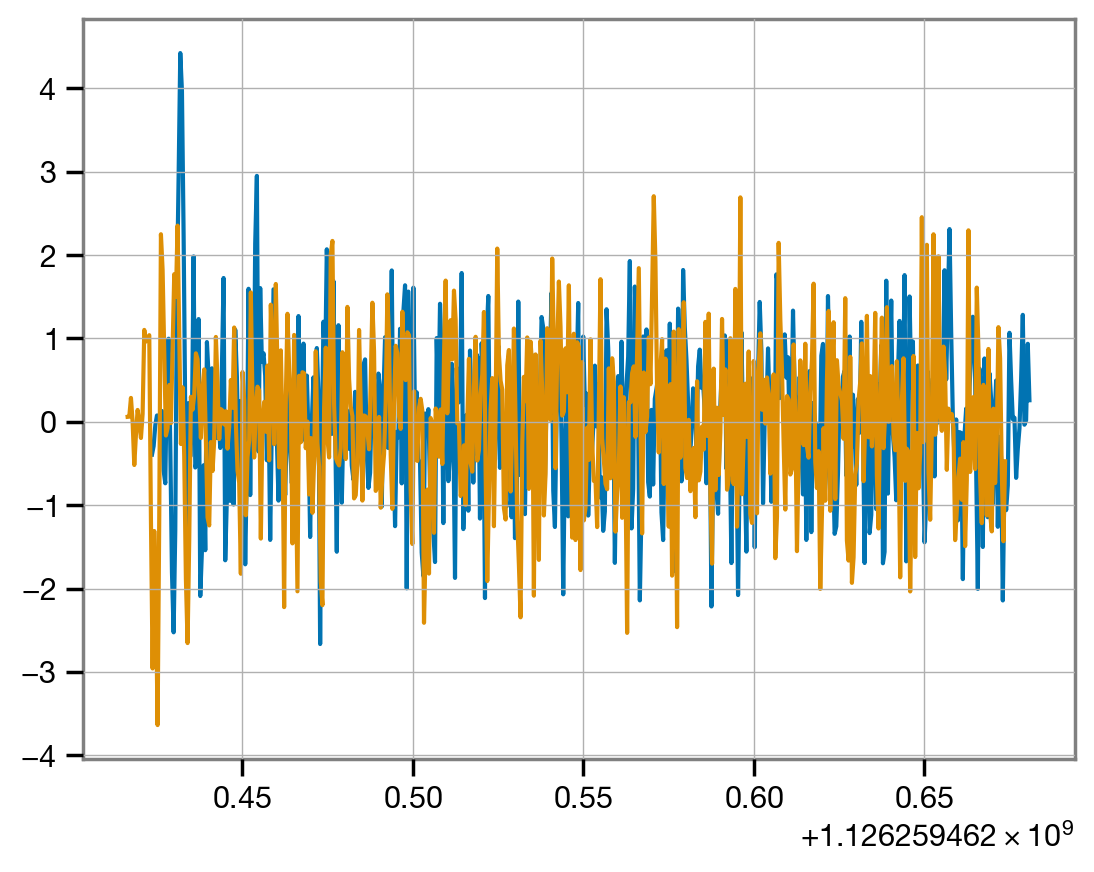

In [25]:
for i, d in fit.whitened_analysis_data.items():
    d.plot()

In [26]:
bpt = fit.imr_result.get_best_peak_times(nsamp=100)[0]

/Users/maxisi/opt/miniconda3/envs/ringdown-jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maxisi/opt/miniconda3/envs/ringdown-jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/maxisi/opt/miniconda3/envs/ringdown-jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ma

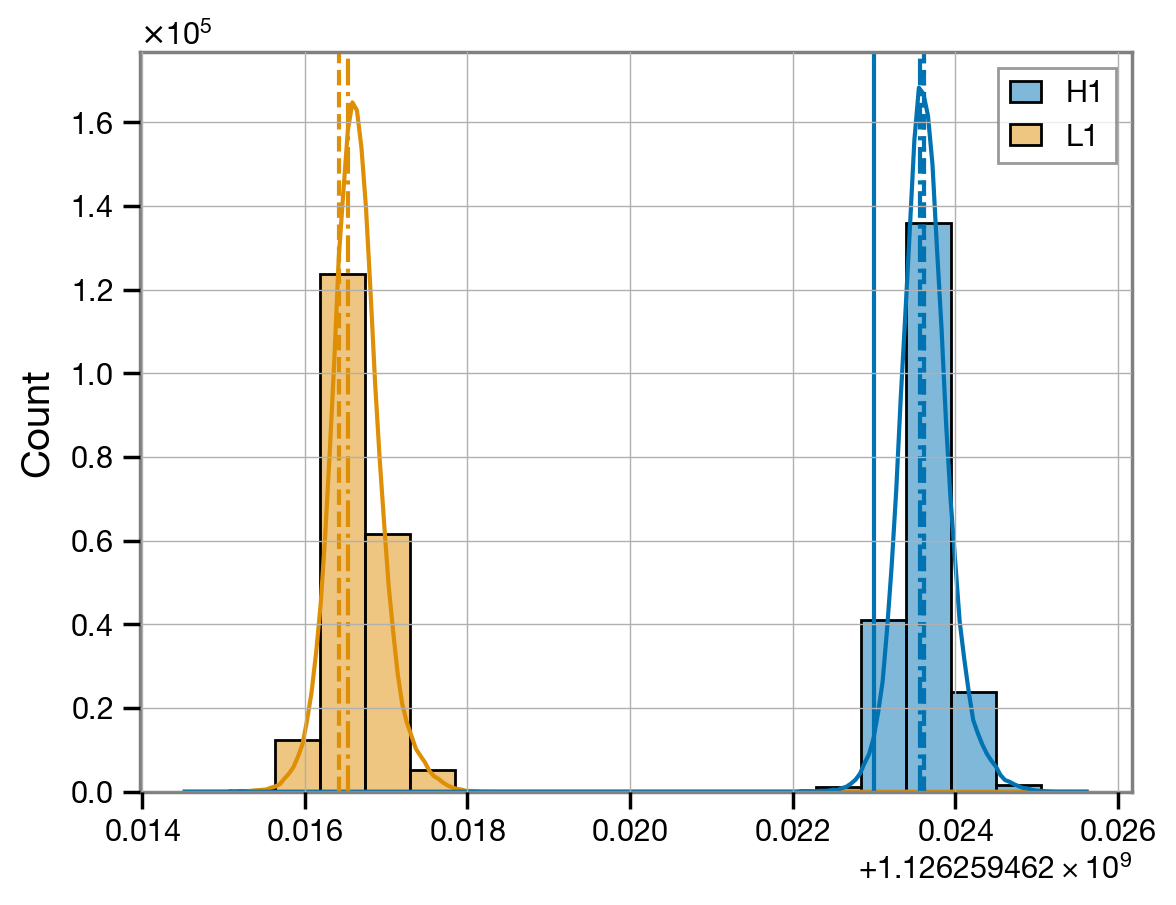

In [27]:
peak_times = fit.imr_result.get_peak_times()
sns.histplot(peak_times, bins=20, kde=True)
plt.axvline(1126259462.423)
plt.axvline(fit.start_times['H1'], ls='--')
plt.axvline(fit.start_times['L1'], ls='--', c='C1')
plt.axvline(bpt['H1'], ls='-.')
plt.axvline(bpt['L1'], ls='-.', c='C1')
plt.axvline(peak_times['H1'].median(), ls=':',)

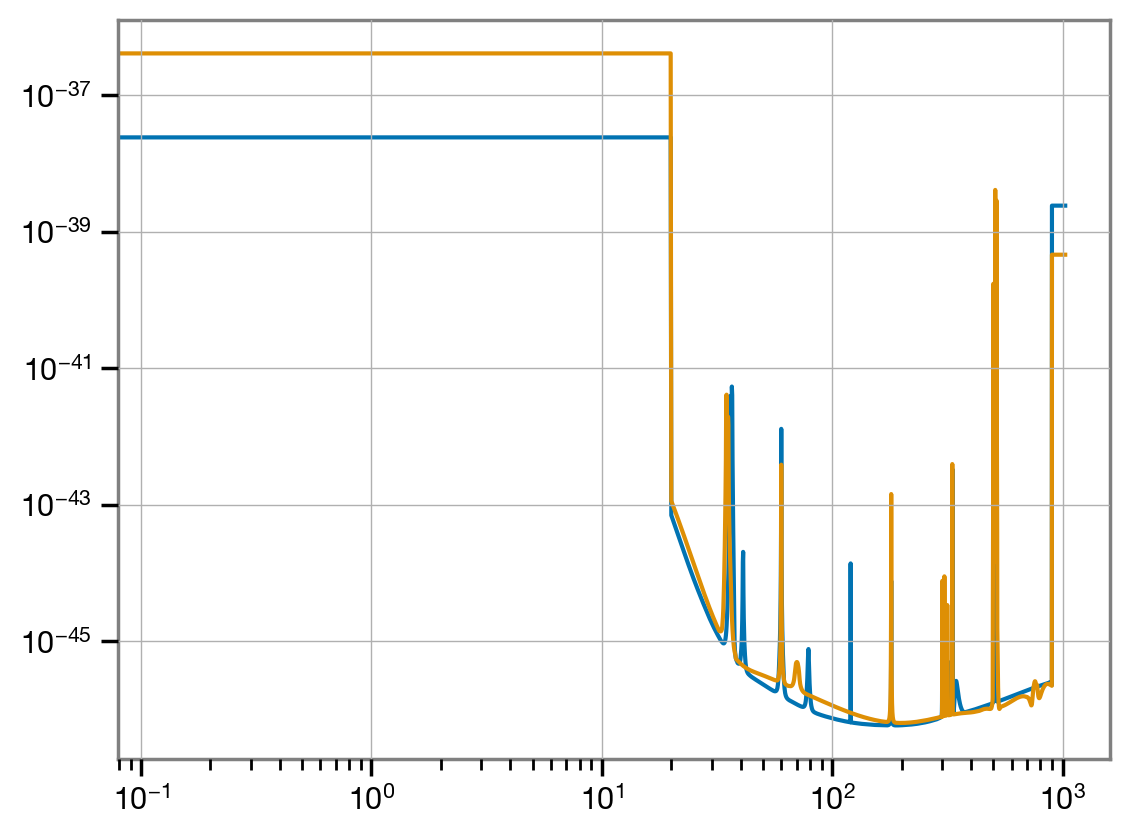

In [28]:
for ifo, acf in fit.acfs.items():
    p = acf.to_psd()
    plt.loglog(p)

In [26]:
fit.update_model(cosi=-1)

In [27]:
fit.model_settings

{'a_scale_max': 6.033146630698385e-20,
 'm_max': 117.0,
 'm_min': 33.0,
 'cosi': -1}

In [35]:
fit.run()

INFO:root:making model
INFO:root:running [(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)] mode fit
INFO:root:prior run: False
INFO:root:model settings: {'a_scale_max': 5.931080515745201e-20, 'm_max': 117.0, 'm_min': 33.0, 'cosi': -1}
INFO:root:kernel settings: {'dense_mass': True}
INFO:root:sampler settings: {'num_warmup': 1000, 'num_samples': 1000, 'num_chains': 4}
INFO:root:run settings: {}
INFO:root:running on 4 CPU using 1 OMP threads
INFO:root:rescaled strain by 1.0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:added strain to observed data
INFO:root:ess = 919 after 1 runs
INFO:root:obtaining predictive distribution
INFO:root:added a to posterior
INFO:root:added ax_unit to posterior
INFO:root:added ay_unit to posterior
INFO:root:added ellip to posterior
INFO:root:added h_det_mode to posterior
INFO:root:added phi to posterior
INFO:root:rescaling strain by 1.0


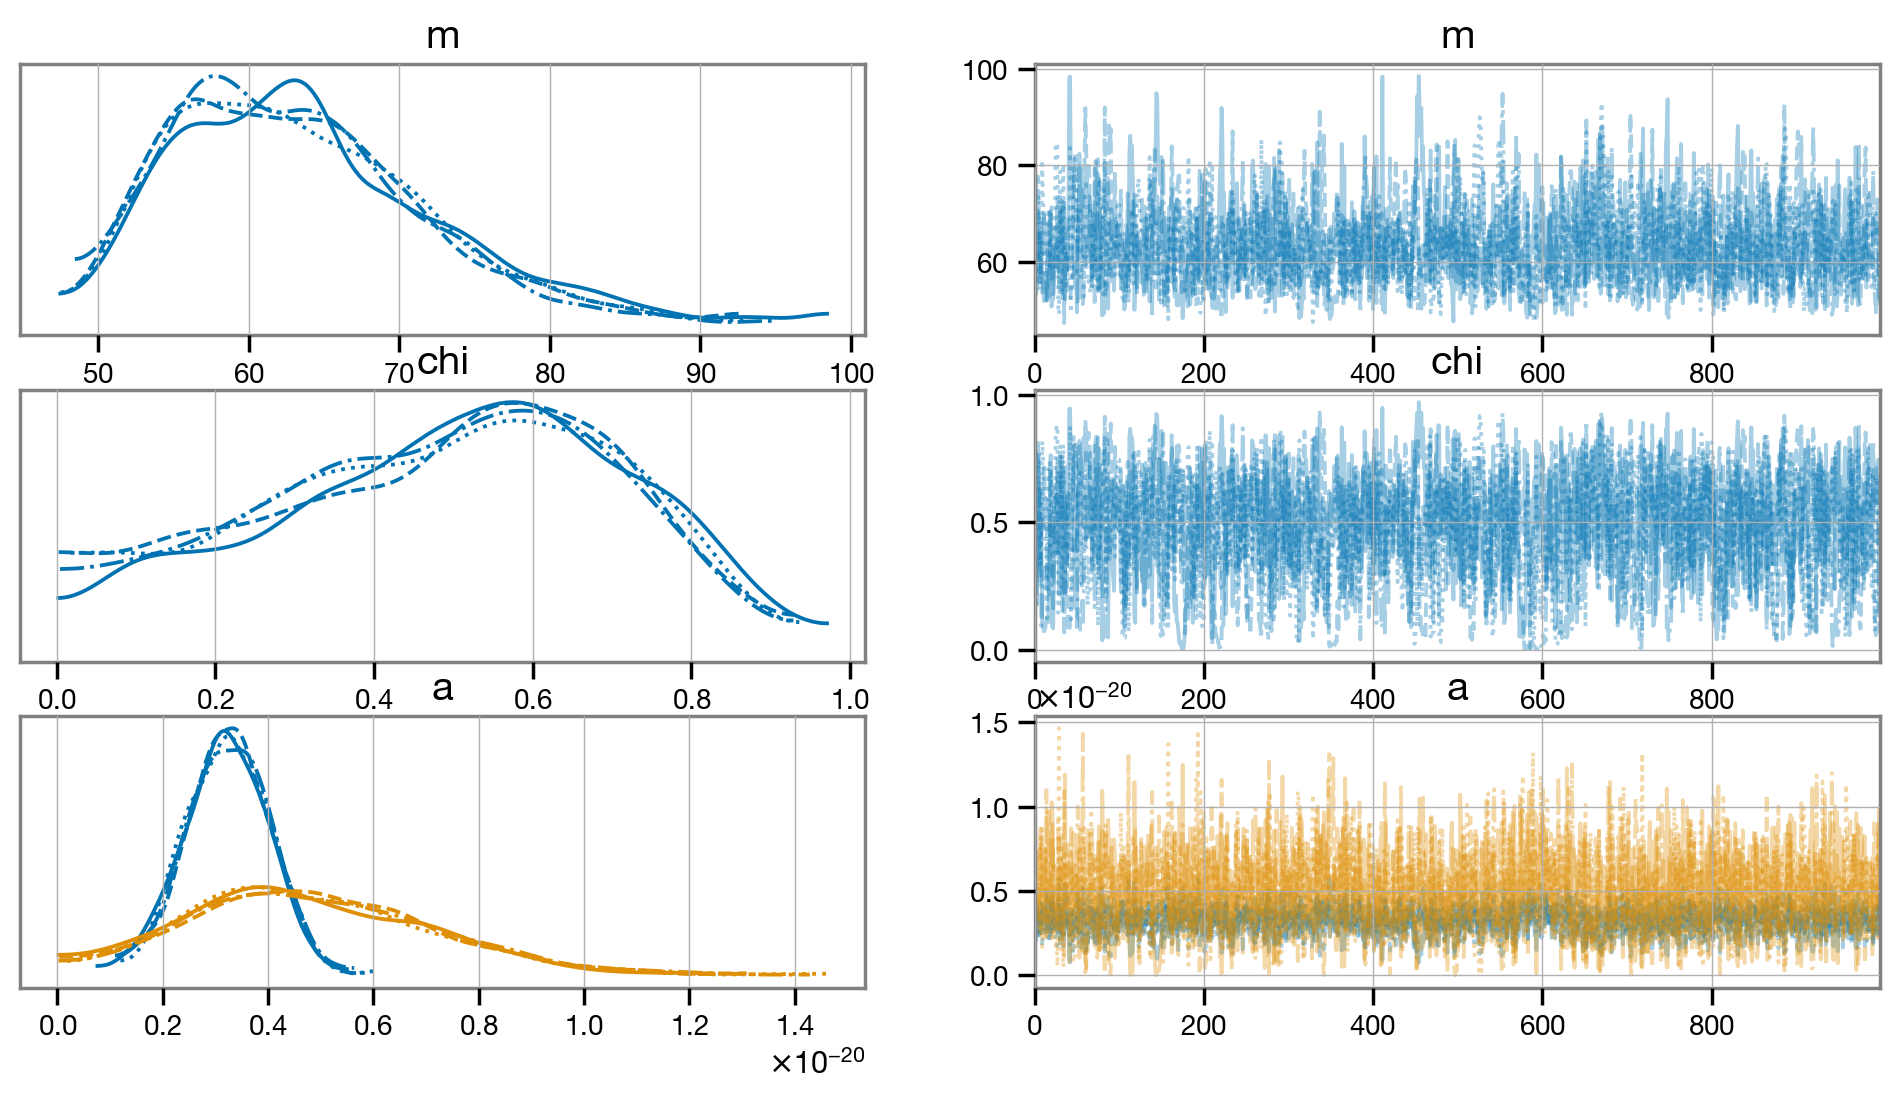

In [36]:
az.plot_trace(fit.result, var_names=['m', 'chi', 'a']);

In [32]:
fit.start_times

{'H1': 1126259462.423613, 'L1': 1126259462.4164212}

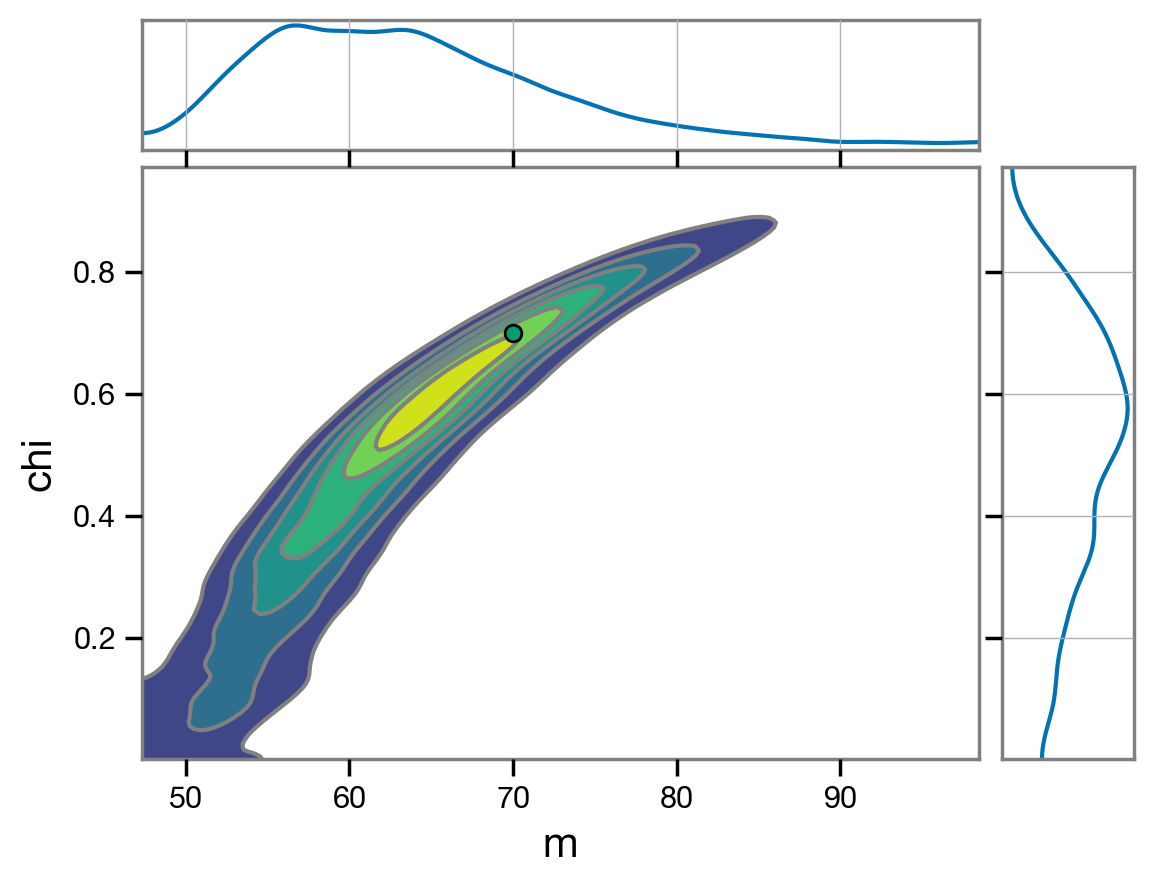

In [37]:
az.plot_pair(fit.result, var_names=['m', 'chi'], marginals=True,
             kind='kde', reference_values={'m': 70, 'chi': 0.7});

In [42]:
rd_samples = fit.result.get_parameter_dataframe(2000)
df_imr = fit.imr_result.sample(2000)

/Users/maxisi/opt/miniconda3/envs/ringdown-jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maxisi/opt/miniconda3/envs/ringdown-jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/maxisi/opt/miniconda3/envs/ringdown-jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/maxisi/opt/miniconda3/envs/ringdown-jax/lib/pytho

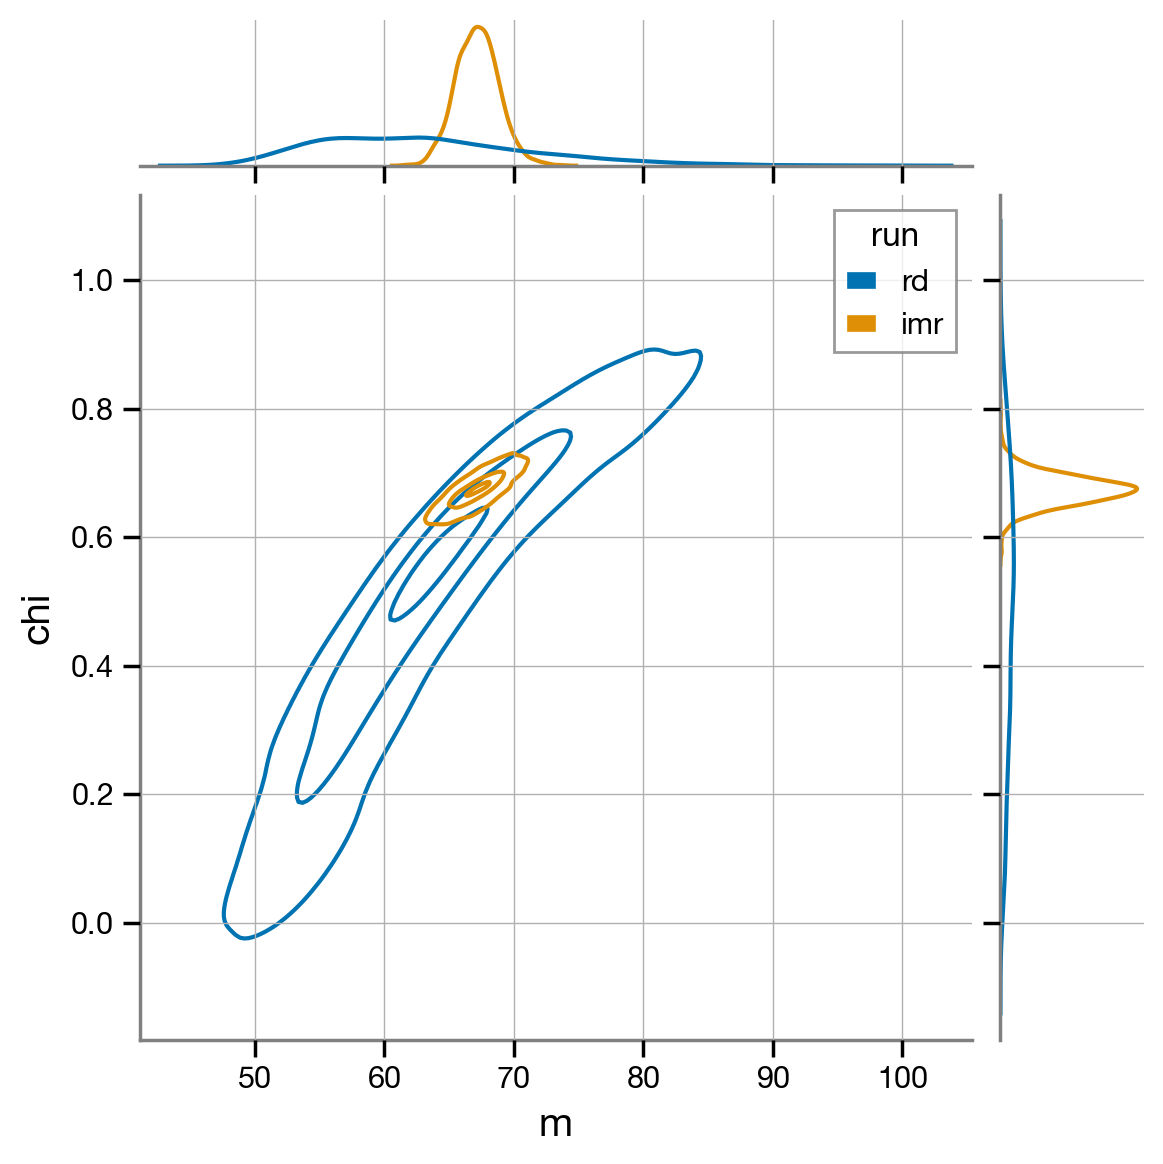

In [46]:
df = rd_samples[['m', 'chi']].copy()
df['run'] = 'rd'

df2 = pd.DataFrame({'m': df_imr.final_mass, 'chi': df_imr.final_spin, 'run': 'imr'})
df = pd.concat([df, df2], ignore_index=True)
sns.jointplot(data=df, x='m', y='chi', kind='kde', hue='run', fill=False, levels=[0.1, 0.5, 0.9], common_norm=False);

In [49]:
# from importlib import reload
# reload(rd.fit)

<module 'ringdown.fit' from '/Users/maxisi/src/ringdown/ringdown/fit.py'>

In [28]:
config = fit.to_config('imr_test_config.ini')

In [30]:
fit2 = rd.fit.Fit.from_config('imr_test_config.ini')

INFO:root:fetching 4.0 s long segment centered on 1126259462.391 [1126259460.391, 1126259464.391]
INFO:root:fetching open data from GWOSC
INFO:root:fetching 4.0 s long segment centered on 1126259462.391 [1126259460.391, 1126259464.391]
INFO:root:fetching open data from GWOSC
INFO:root:unused keyword arguments: {'ifos': ['H1', 'L1']}
